<a href="https://colab.research.google.com/github/Viktor193/Diplom_innopolis/blob/main/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D0%B0%D1%8F_%D0%B0%D1%82%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%9D%D0%B8%D0%BA%D0%B8%D1%82%D0%B5%D0%BD%D0%BA%D0%BE_%D0%92_%D0%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Введение. Постановка целей и задач.

Для анализа был выбран датасет с суммой розничных продаж алкогольной продукции в США.

**Цель**: проведение исследования данных и построение прогноза суммы продаж алкогольной продукции.

**Задачи**:

1. Провести анализ данных о суммах продаж алкогольной продукции;
2. Построить прогноз суммы продаж алкогольной продукции.

## Импорт библиотек, ознакомление с данными.

In [12]:
# загружаем pmdarima
!pip install pmdarima
# загружаем fbprophet
!pip install fbprophet
# загружаем pyspark
!pip install pyspark

In [13]:
## Здесь импортируем библиотеки и функции 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# импорт моделей 
from statsmodels.tsa.statespace.sarimax import SARIMAX       # для модели SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей (подбирает оптимальные параметры для модели)
from fbprophet import Prophet                                # для модели Профет
from statsmodels.tsa.holtwinters import ExponentialSmoothing # для модели Экспоненцальное сглаживание

# метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

from pyspark.sql.types import DoubleType, IntegerType, DateType
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import *

In [16]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession #to define a SparkSession

sc = SparkContext('local') #spark_connection
spark = SparkSession(sc) # open spark session

In [15]:
 # !Важно не запускать при необходимсоти открытой сесси
 spark.stop()

In [17]:
url = 'https://raw.githubusercontent.com/Viktor193/Diplom_innopolis/main/Retail_Sales_Beer_Liquor.csv'
from pyspark import SparkFiles
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("Retail_Sales_Beer_Liquor.csv"), header=True)

### **1. Знакомство с данными.**

In [18]:
## Проверяем загрузку
df.head()

Row(DATE='1992-01-01', MRTSSM4453USN='1509')

In [19]:
#Смотрим на типы атрибутов исходного файла
df.printSchema()

root
 |-- DATE: string (nullable = true)
 |-- MRTSSM4453USN: string (nullable = true)



**1.2. Предобработка данных**

In [20]:
#Преобразуем названия колонок, создав новый датафрейм
newColumns = ["DATA","Volume of sales"]
df_new = df.toDF(*newColumns)

#Преобразуем сумму продаж в число с плавающей точкой и даты в формат даты
df_new = df_new \
    .withColumn('Volume of sales', col('Volume of sales').cast(DoubleType()))\
    .withColumn('DATA', col('DATA').cast(DateType()))

In [21]:
#Посмотрим на преобразование
df_new.show(10)

+----------+---------------+
|      DATA|Volume of sales|
+----------+---------------+
|1992-01-01|         1509.0|
|1992-02-01|         1541.0|
|1992-03-01|         1597.0|
|1992-04-01|         1675.0|
|1992-05-01|         1822.0|
|1992-06-01|         1775.0|
|1992-07-01|         1912.0|
|1992-08-01|         1862.0|
|1992-09-01|         1770.0|
|1992-10-01|         1882.0|
+----------+---------------+
only showing top 10 rows



In [22]:
#посмотрим на типы атрибутов
df_new.printSchema() 

root
 |-- DATA: date (nullable = true)
 |-- Volume of sales: double (nullable = true)



In [23]:
# Проверка пустых значений
df_new.filter( (col('DATA')=='') | (col('Volume of sales')=='')).show()

+----+---------------+
|DATA|Volume of sales|
+----+---------------+
+----+---------------+



**Заключение по Блоку 1:**
 1. Загружен иследуемый датасет;
 2. Изменено название поля "MRTSSM4453USN" на более информативное "Volume of sales"; 
 3. Проверены типы данных, и выполнено преобразование из string: 
  -  В data для поля DATA;
  - В double для поля "Volume of sales".
 4. Датасет проверен на пропуски: **пропуски отсутсвуют**.



###**2. EDA (exploratory data analysis) или разведочный анализ данных.**

**Цель**: познакомиться "поближе" с данными, которыми мы располагаем.

**Задачи**:

1. Сделать столбец с датами индексом;
2. Вывести статистику по нужным столбцам;
3. Построить графическое отображение столбцов;
4. Выявить связи между признаками.

In [24]:
# Смотрим размер выборки
df_new.count()

324

In [25]:
#Преобразование данных в dataframe pandas
df1=df_new.toPandas()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DATA             324 non-null    object 
 1   Volume of sales  324 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.2+ KB


In [26]:
# Сделать столбец с датами индексом
df1['DATA'] = pd.to_datetime(df1['DATA'])
df1.index = df1.DATA
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 1992-01-01 to 2018-12-01
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DATA             324 non-null    datetime64[ns]
 1   Volume of sales  324 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.6 KB


In [27]:
# Проведем расчет основных статистических метрик
df1.describe()

,Volume of sales
count,324.000000
mean,2972.895062
std,1010.218574
min,1501.000000
25%,2109.000000
50%,2791.000000
75%,3627.250000
max,6370.000000


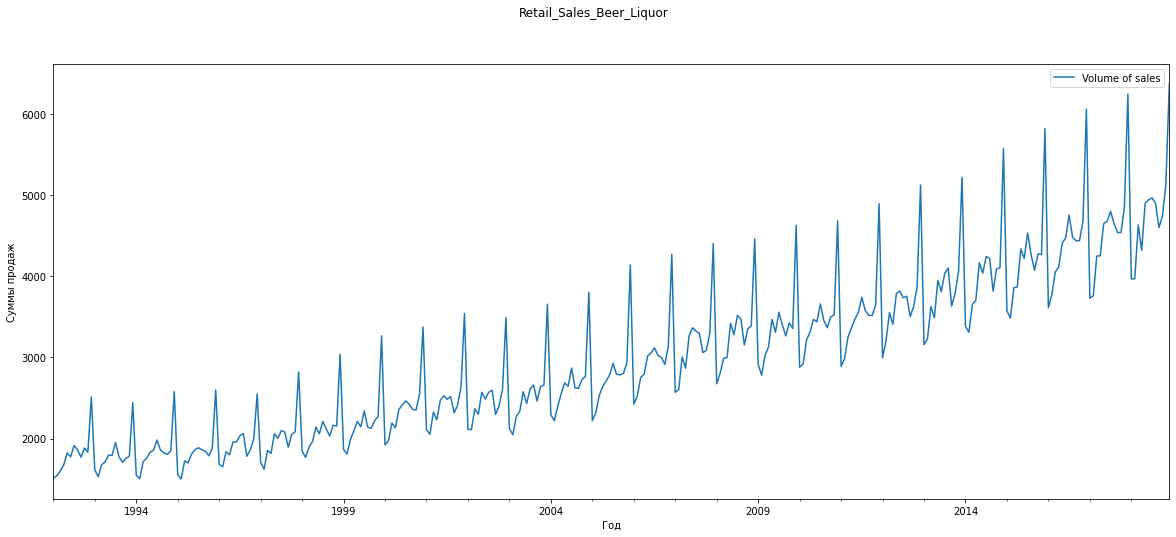

In [28]:
#построим общий график для метрик
df1[['Volume of sales']].plot(subplots=True, figsize=(20, 8), ylabel='Суммы продаж',  xlabel='Год', title = 'Retail_Sales_Beer_Liquor');

**Промежуточный вывод:**
 1. Общий тренд восходящий: сумма продаж с каждым годом увеличивается;
 2. Присутствует сезонное увеличение суммы продаж.

**Строим гипотезу:** увеличение суммы продаж в дальнейшем с сохранением  сезонности.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f72898221d0>]],
      dtype=object)

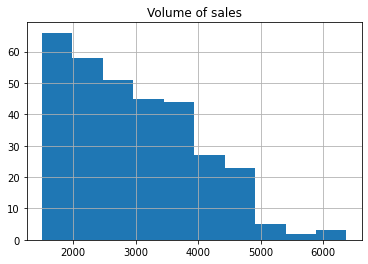

In [29]:
## построим гистограмму для определения распределения данных
df1[['Volume of sales']].hist()

Промежуточный вывод:

Анализ разспределния позволяет сделать вывод что больше всего месяцев с наименьшими суммами продаж, чем выше сумма продаж тем меньше месяцев с такими суммами

### **3. Построение моделей, анализ результатов.**

In [30]:
# выделяем выборки, где тестовая размера 1 год
train = df1.iloc[:len(df1)-12]
test = df1.iloc[len(df1)-12:]

In [31]:
#посмотрим на обучающую выборку
train.head()

,DATA,Volume of sales
DATA,,
1992-01-01,1992-01-01,1509.0
1992-02-01,1992-02-01,1541.0
1992-03-01,1992-03-01,1597.0
1992-04-01,1992-04-01,1675.0
1992-05-01,1992-05-01,1822.0


In [32]:
#посмотрим на обучающую выборку
test.head()

,DATA,Volume of sales
DATA,,
2018-01-01,2018-01-01,3965.0
2018-02-01,2018-02-01,3967.0
2018-03-01,2018-03-01,4629.0
2018-04-01,2018-04-01,4317.0
2018-05-01,2018-05-01,4897.0


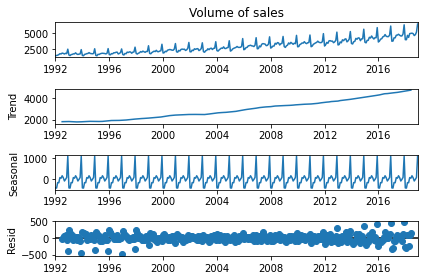

In [33]:
# строим декомпозицию временного ряда (ETS декомпозиция)
r = seasonal_decompose(df1['Volume of sales'],model='additive')
r.plot();

**Промежуточный вывод**: Наблюдаем годовую сезонность и положительный тренд.

**Задачи:**

1. Описать модель;
2. Подобрать оптимальные параметры;
3. Создать модель несколько типов моделей;
4. Обучить модель;
5. Сделать прогноз на период тестовой выборки;
6. Сравнить прогноз с тестовой выборкой (построить график);
7. Оценить качество прогноза;
8. Сделать прогноз на год;
9. Сделать выводы о работе данного метода прогнозирования.

**Модель 1: SARIMAX**

In [34]:
# запускаем pmdarima.auto_arima чтобы получить набор параметров
auto_arima(df1['Volume of sales'],seasonal=True,m=12).summary() # включаем сезонность и указываем период сезонности равный 1 год

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  324
Model:             SARIMAX(4, 1, 3)x(2, 1, [1], 12)   Log Likelihood               -1774.379
Date:                              Mon, 21 Mar 2022   AIC                           3570.758
Time:                                      21:44:09   BIC                           3611.896
Sample:                                           0   HQIC                          3587.202
                                              - 324                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0168      0.090    -11.270      0.000      -1.194      -0.840
ar.L2         -0.5759      0.161     -3.571      0.000      -0.892      -0.260
ar.L3          0.4407      0.161      2.744      0.006       0.126       0.755
ar.L4          0.2613      0.090      2.896      0.004       0.084       0.438
ma.L1          0.2127      0.064      3.315      0.001       0.087       0.338
ma.L2         -0.0356      0.064     -0.558      0.577      -0.161       0.090
ma.L3         -0.8716      0.049    -17.710      0.000      -0.968      -0.775
ar.S.L12      -0.9057      0.346     -2.620      0.009      -1.583      -0.228
ar.S.L24      -0.2280      0.080     -2.860      0.004      -0.384      -0.072
ma.S.L12       0.6628      0.345      1.919      0.055      -0.014       1.340
sigma2      5918.8245    521.416     11.351      0.000    4896.868    6940.781
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 1.66
Prob(Q):                              0.67   Prob(JB):                         0.44
Heteroskedasticity (H):               2.02   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
# создаем модель с подобранными параметрами
model_sarimax = SARIMAX(train['Volume of sales'],order=(4, 1, 3), seasonal_order=(2, 1, 1, 12))

# обучаем модель на обучающей выборке данных
results_sarimax = model_sarimax.fit()

# получаем результаты
results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      Volume of sales   No. Observations:                  312
Model:             SARIMAX(4, 1, 3)x(2, 1, [1], 12)   Log Likelihood               -1704.134
Date:                              Mon, 21 Mar 2022   AIC                           3430.268
Time:                                      21:45:01   BIC                           3470.972
Sample:                                  01-01-1992   HQIC                          3446.559
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9567      0.102     -9.411      0.000      -1.156      -0.757
ar.L2         -0.4635      0.169     -2.748      0.006      -0.794      -0.133
ar.L3          0.5419      0.166      3.261      0.001       0.216       0.868
ar.L4          0.2974      0.099      3.001      0.003       0.103       0.492
ma.L1          0.1851      0.076      2.439      0.015       0.036       0.334
ma.L2         -0.0569      0.075     -0.763      0.446      -0.203       0.089
ma.L3         -0.8670      0.056    -15.584      0.000      -0.976      -0.758
ar.S.L12       0.1140      0.602      0.189      0.850      -1.065       1.293
ar.S.L24      -0.0357      0.171     -0.209      0.835      -0.371       0.300
ma.S.L12      -0.3495      0.604     -0.579      0.563      -1.533       0.834
sigma2      6152.6193    597.072     10.305      0.000    4982.380    7322.858
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.67   Prob(JB):                         0.41
Heteroskedasticity (H):               1.97   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# получаем предсказанные значения и пытаемся оценить качество прогноза
start=len(train) # первая точка в тестовом множестве
end=len(train)+len(test)-1 # последняя точка в тестовом множестве

# предсказываем значения,передав модели results точку начала и окончания
predictions = results_sarimax.predict(start=start, end=end, dynamic=False, typ='levels').rename('Predictions SARIMAX(4, 1, 3)x(2, 1, 1, 12)')

[Text(0, 0.5, 'Суммы продаж'), Text(0.5, 0, 'Месяц')]

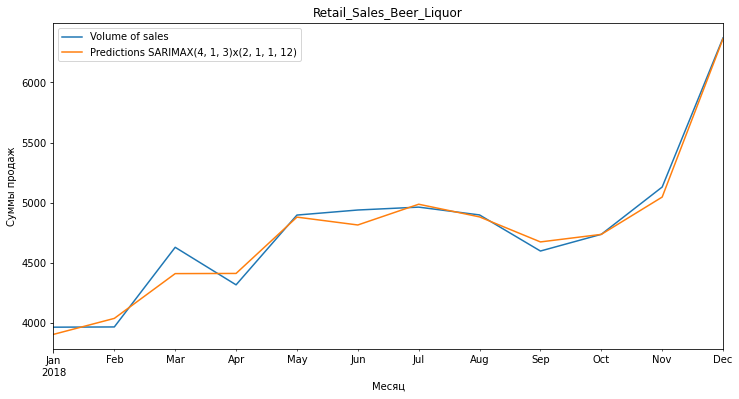

In [37]:
# сравниваем результаты

title = 'Retail_Sales_Beer_Liquor' # название графика
ylabel = 'Суммы продаж' # название оси Y
xlabel = 'Месяц' # название оси Х
ax = test['Volume of sales'].plot(legend=True, figsize=(12,6),title=title) # добавлем заголовок
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [38]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['Volume of sales'], predictions)
mse_error = mean_squared_error(test['Volume of sales'], predictions)
rmse_error = rmse(test['Volume of sales'], predictions)
mape_error = np.mean(np.abs(predictions - test['Volume of sales'])/test['Volume of sales'])*100

print(f'Predictions SARIMAX(4, 1, 3)x(2, 1, 1, 12) MAE Error: {mae_error:11.10}')
print(f'Predictions SARIMAX(4, 1, 3)x(2, 1, 1, 12) MSE Error: {mse_error:11.10}')
print(f'Predictions SARIMAX(4, 1, 3)x(2, 1, 1, 12) RMSE Error: {rmse_error:11.10}')
print(f'Predictions SARIMAX(4, 1, 3)x(2, 1, 1, 12) MAPE Error: {mape_error:11.10}')

Predictions SARIMAX(4, 1, 3)x(2, 1, 1, 12) MAE Error: 66.06013915
Predictions SARIMAX(4, 1, 3)x(2, 1, 1, 12) MSE Error: 7896.543616
Predictions SARIMAX(4, 1, 3)x(2, 1, 1, 12) RMSE Error: 88.86249837
Predictions SARIMAX(4, 1, 3)x(2, 1, 1, 12) MAPE Error: 1.441353299


In [39]:
#делаем прогноз на будущее - 1 год вперед
# обучаем модель на всем датасете
fut_model_sarimax = SARIMAX(df1['Volume of sales'],order=(4, 1, 3), seasonal_order=(2, 1, 1, 12))
fut_results_sarimax = fut_model_sarimax.fit()
fut_results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      Volume of sales   No. Observations:                  324
Model:             SARIMAX(4, 1, 3)x(2, 1, [1], 12)   Log Likelihood               -1774.379
Date:                              Mon, 21 Mar 2022   AIC                           3570.758
Time:                                      21:45:27   BIC                           3611.896
Sample:                                  01-01-1992   HQIC                          3587.202
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0168      0.090    -11.270      0.000      -1.194      -0.840
ar.L2         -0.5759      0.161     -3.571      0.000      -0.892      -0.260
ar.L3          0.4407      0.161      2.744      0.006       0.126       0.755
ar.L4          0.2613      0.090      2.896      0.004       0.084       0.438
ma.L1          0.2127      0.064      3.315      0.001       0.087       0.338
ma.L2         -0.0356      0.064     -0.558      0.577      -0.161       0.090
ma.L3         -0.8716      0.049    -17.710      0.000      -0.968      -0.775
ar.S.L12      -0.9057      0.346     -2.620      0.009      -1.583      -0.228
ar.S.L24      -0.2280      0.080     -2.860      0.004      -0.384      -0.072
ma.S.L12       0.6628      0.345      1.919      0.055      -0.014       1.340
sigma2      5918.8245    521.416     11.351      0.000    4896.868    6940.781
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 1.66
Prob(Q):                              0.67   Prob(JB):                         0.44
Heteroskedasticity (H):               2.02   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

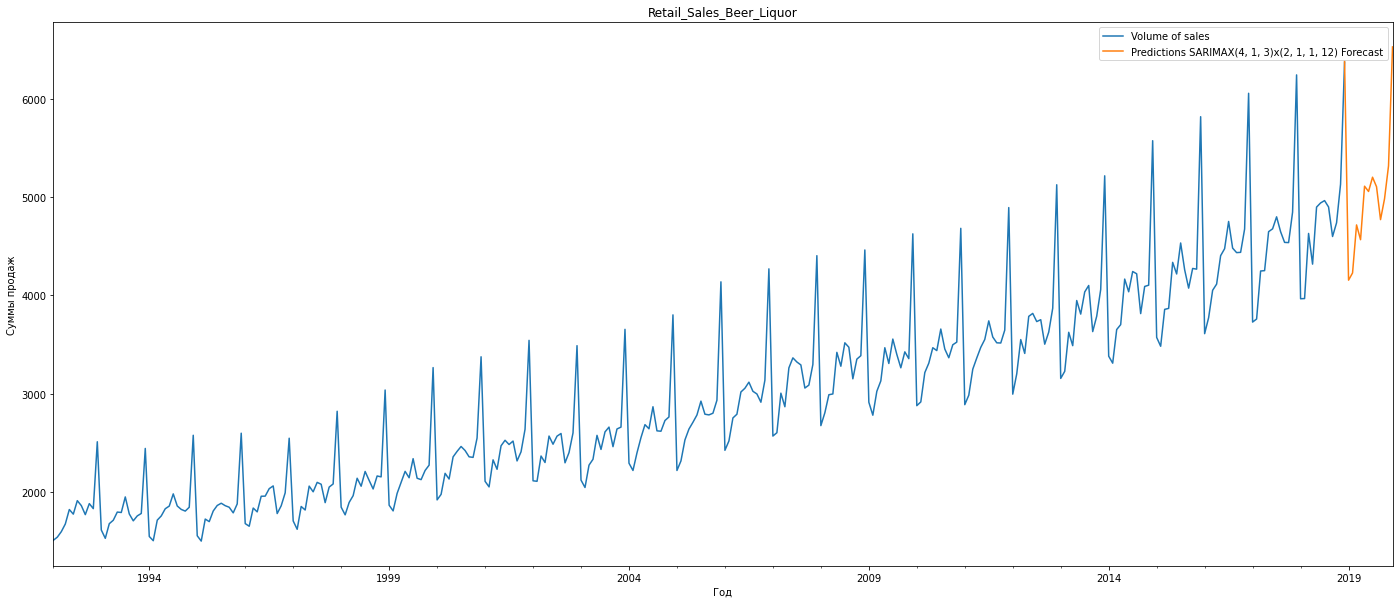

In [40]:
#задаем точки будущего
fut_fcast_sarimax = fut_results_sarimax.predict(len(df1)-1,len(df1)+11,typ='levels').rename('Predictions SARIMAX(4, 1, 3)x(2, 1, 1, 12) Forecast')

#строим график на будущее
ax = df1['Volume of sales'].plot(legend=True, figsize=(24,10), ylabel='Суммы продаж',  xlabel='Год',title='Retail_Sales_Beer_Liquor') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

**Выводы работы метода SARIMAX**
1. Модель показала себя хорошо: RMSE=88.86- это хороший показатель.
2. Процент рассчитанной ошибки MAPE=1.44%, это хороший результат.
3. Согласно графику, на будущее видим, что тренд и высота амплитуда были отображены корректно, общая динамика прослеживается.

**Модель 2: PROPHET**

In [41]:
# подготовим данные для модели
train_prophet = train[['DATA','Volume of sales']]
test_prophet = test[['DATA','Volume of sales']]

# Переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet
train_prophet.columns = ['ds', 'y'] # переименовали столбцы
test_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [42]:
# подготовим данные по всему датасету для модели
df1_prophet = df1[['DATA','Volume of sales']]
df1_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [43]:
model_prophet = Prophet(seasonality_mode='multiplicative')
#обучаем модель на обучающей выборке данных
model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
# говорим профету сделать дата-фрейм на 1 год
future_prophet = model_prophet.make_future_dataframe(periods=12,freq='MS')
future_prophet.tail(12) # выводим 12 строк с конца

,ds
312,2018-01-01
313,2018-02-01
314,2018-03-01
315,2018-04-01
316,2018-05-01
317,2018-06-01
318,2018-07-01
319,2018-08-01
320,2018-09-01
321,2018-10-01


In [45]:
##предсказываем значения по модели
prediction_prophet = model_prophet.predict(future_prophet)
prediction_prophet.head() # возвращает много колонок

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1992-01-01,1784.258902,1424.917923,1570.910361,1784.258902,1784.258902,-0.159110,-0.159110,-0.159110,-0.159110,-0.159110,-0.159110,0.0,0.0,0.0,1500.365543
1,1992-02-01,1786.020989,1449.961461,1609.979721,1786.020989,1786.020989,-0.143557,-0.143557,-0.143557,-0.143557,-0.143557,-0.143557,0.0,0.0,0.0,1529.625391
2,1992-03-01,1787.669394,1600.172774,1758.183555,1787.669394,1787.669394,-0.062380,-0.062380,-0.062380,-0.062380,-0.062380,-0.062380,0.0,0.0,0.0,1676.154767
3,1992-04-01,1789.431481,1587.062068,1750.196154,1789.431481,1789.431481,-0.066063,-0.066063,-0.066063,-0.066063,-0.066063,-0.066063,0.0,0.0,0.0,1671.215573
4,1992-05-01,1791.136727,1743.436500,1907.855195,1791.136727,1791.136727,0.017738,0.017738,0.017738,0.017738,0.017738,0.017738,0.0,0.0,0.0,1822.907379


In [46]:
#устанавливаем индекс
prediction_prophet.index = prediction_prophet.ds
prediction_prophet.head() # проверим изменения

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
1992-01-01,1992-01-01,1784.258902,1424.917923,1570.910361,1784.258902,1784.258902,-0.159110,-0.159110,-0.159110,-0.159110,-0.159110,-0.159110,0.0,0.0,0.0,1500.365543
1992-02-01,1992-02-01,1786.020989,1449.961461,1609.979721,1786.020989,1786.020989,-0.143557,-0.143557,-0.143557,-0.143557,-0.143557,-0.143557,0.0,0.0,0.0,1529.625391
1992-03-01,1992-03-01,1787.669394,1600.172774,1758.183555,1787.669394,1787.669394,-0.062380,-0.062380,-0.062380,-0.062380,-0.062380,-0.062380,0.0,0.0,0.0,1676.154767
1992-04-01,1992-04-01,1789.431481,1587.062068,1750.196154,1789.431481,1789.431481,-0.066063,-0.066063,-0.066063,-0.066063,-0.066063,-0.066063,0.0,0.0,0.0,1671.215573
1992-05-01,1992-05-01,1791.136727,1743.436500,1907.855195,1791.136727,1791.136727,0.017738,0.017738,0.017738,0.017738,0.017738,0.017738,0.0,0.0,0.0,1822.907379


Промежуточные выводы:

Основные поля в прогнозе следующие:

ds — дата прогноза
yhat — спрогнозированное значение
yhat_lower — нижняя граница доверительного интервала для прогноза
yhat_upper — верхняя граница доверительного интервала для прогноза

In [47]:
prediction_prophet[['ds', 'yhat']] # оставим только нужные

,ds,yhat
ds,,
1992-01-01,1992-01-01,1500.365543
1992-02-01,1992-02-01,1529.625391
1992-03-01,1992-03-01,1676.154767
1992-04-01,1992-04-01,1671.215573
1992-05-01,1992-05-01,1822.907379
...,...,...
2018-08-01,2018-08-01,4867.041933
2018-09-01,2018-09-01,4627.190349
2018-10-01,2018-10-01,4765.232822


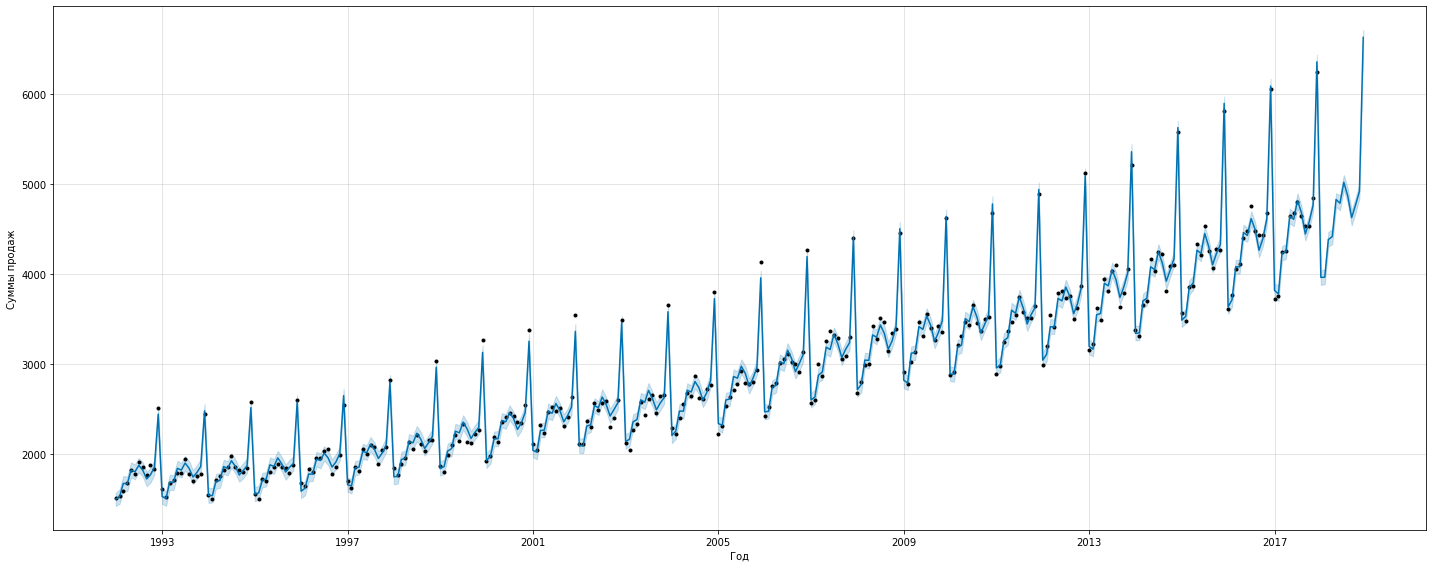

In [48]:
#сравниваем прогноз и тестовую выборку, где черные точки - выборка
model_prophet.plot(prediction_prophet, figsize=(20,8), ylabel='Суммы продаж',  xlabel='Год',);

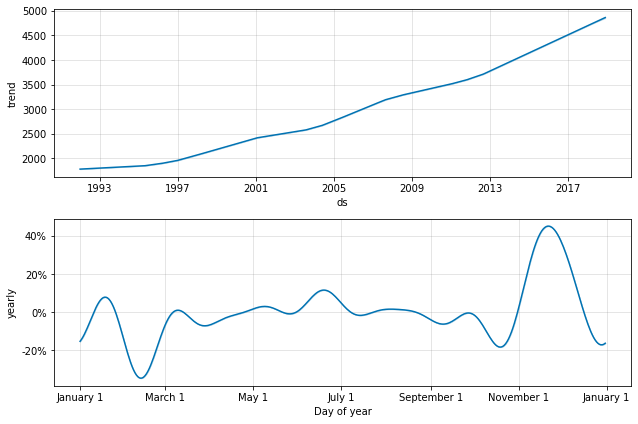

In [49]:
# разложим ряд на основные компоненты — тренд и сезонность
model_prophet.plot_components(prediction_prophet);

**Промежуточные выводы**:

Видим, что тренд розничных продаж возрастающий, а также есть годовая сезонность.

Видим каким образом изменяются продажи по месяцам.

In [50]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test_prophet['y'], prediction_prophet['yhat'].tail(12))
mse_error = mean_squared_error(test_prophet['y'], prediction_prophet['yhat'].tail(12))
rmse_error = rmse(test_prophet['y'], prediction_prophet['yhat'].tail(12))
mape_error = np.mean(np.abs(prediction_prophet['yhat'] - test_prophet['y'])/test_prophet['y'])*100

print(f'Prophet MAE Error: {mae_error:11.10}')
print(f'Prophet MSE Error: {mse_error:11.10}')
print(f'Prophet RMSE Error: {rmse_error:11.10}')
print(f'Prophet MAPE Error: {mape_error:11.10}')

Prophet MAE Error: 98.73289647
Prophet MSE Error: 17973.33688
Prophet RMSE Error: 134.0646743
Prophet MAPE Error: 1.947700413


In [51]:
#делаем прогноз на будущее - 1 год вперед

# обучаем модель на всем датасете
fut_model_prophet = Prophet(seasonality_mode='multiplicative')
fut_model_prophet.fit(df1_prophet)

# говорим профету сделать дата-фрейм на 1 год
fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=12, freq='MS')
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


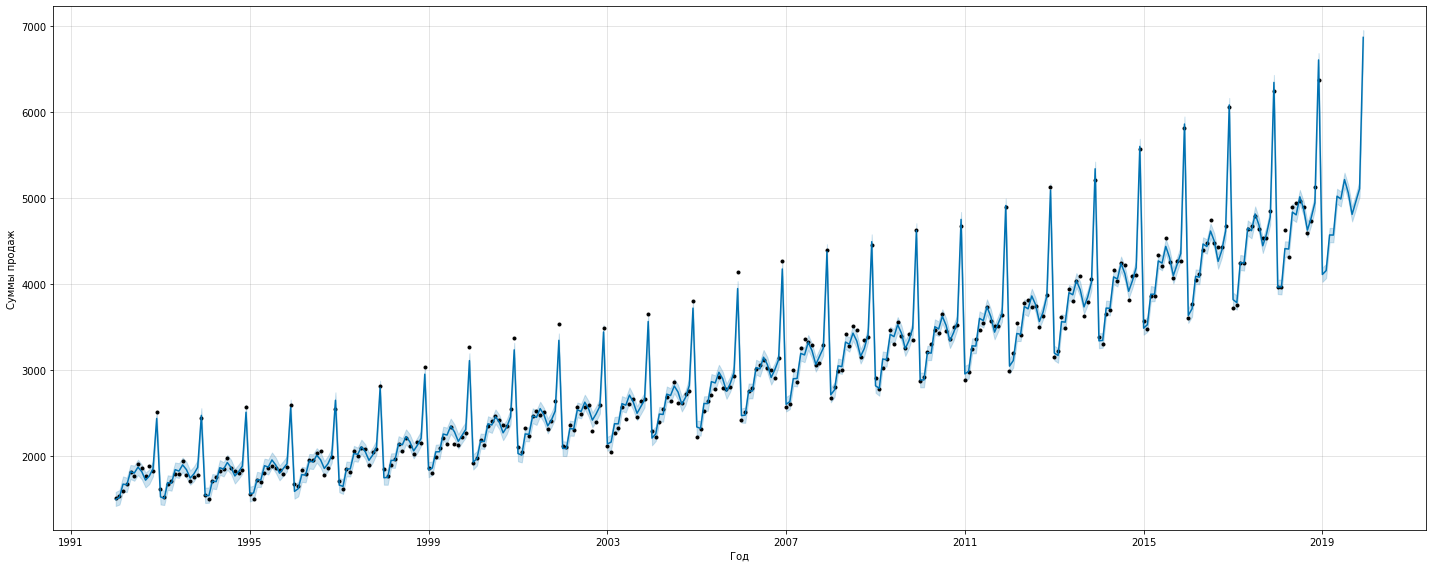

In [52]:
#сравниваем прогноз и всю выборку, где черные точки - входная выборка
fut_model_prophet.plot(fut_fcast_prophet, figsize=(20,8), ylabel='Суммы продаж',  xlabel='Год');

In [53]:
#устанавливаем индекс
fut_fcast_prophet.index = fut_fcast_prophet.ds

In [54]:
# убедимся в изменениях
fut_fcast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
1992-01-01,1992-01-01,1779.686013,1421.076333,1584.703581,1779.686013,1779.686013,-0.159144,-0.159144,-0.159144,-0.159144,-0.159144,-0.159144,0.0,0.0,0.0,1496.459598
1992-02-01,1992-02-01,1781.689113,1438.493271,1606.809887,1781.689113,1781.689113,-0.144187,-0.144187,-0.144187,-0.144187,-0.144187,-0.144187,0.0,0.0,0.0,1524.792775
1992-03-01,1992-03-01,1783.562982,1589.639508,1765.394521,1783.562982,1783.562982,-0.060513,-0.060513,-0.060513,-0.060513,-0.060513,-0.060513,0.0,0.0,0.0,1675.633708
1992-04-01,1992-04-01,1785.566083,1583.102628,1749.580489,1785.566083,1785.566083,-0.066158,-0.066158,-0.066158,-0.066158,-0.066158,-0.066158,0.0,0.0,0.0,1667.436368
1992-05-01,1992-05-01,1787.504567,1734.744302,1898.312781,1787.504567,1787.504567,0.018569,0.018569,0.018569,0.018569,0.018569,0.018569,0.0,0.0,0.0,1820.696922


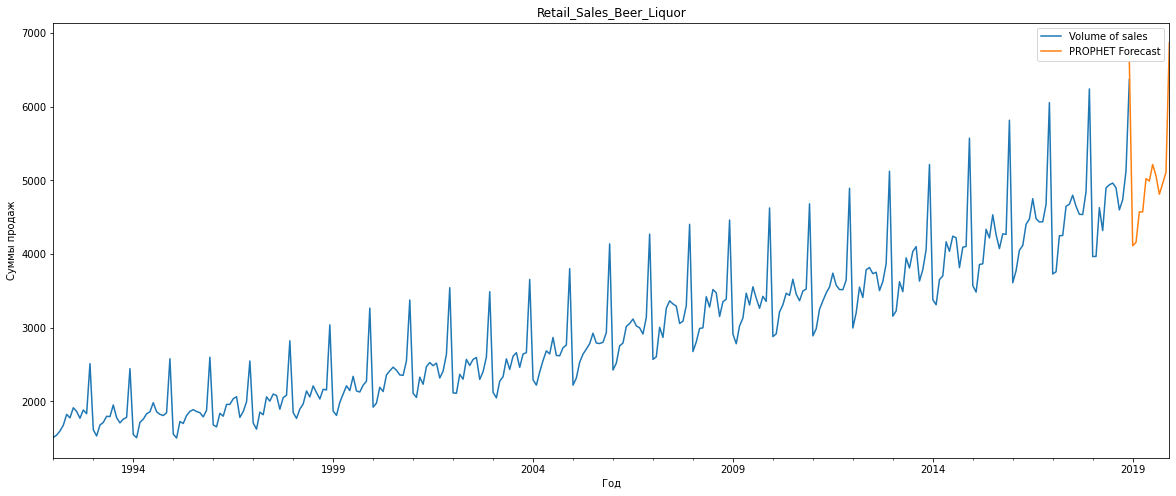

In [55]:
#строим график на будущее
ax = df1_prophet['y'].plot(legend=True, figsize=(20,8),title='Retail_Sales_Beer_Liquor') 
fut_fcast_prophet['yhat'].tail(13).plot(legend=True, ylabel='Суммы продаж',  xlabel='Год',)
ax.autoscale(axis='x',tight=True)
ax.legend(["Volume of sales", "PROPHET Forecast"]);



### Выводы работы метода PROPHET
Модель показала себя хорошо:
1. Модель показала себя хорошо: RMSE=134.06- это хороший показатель.
2. Процент рассчитанной ошибки MAPE=1.94%, это хороший результат.
3. Согласно графику, на будущее видим, что тренд и высота амплитуда были отображены корректно, общая динамика прослеживается.

**Модель 3: "Экспоненциальное сглаживание" (Exponential smoothing)**

**Описание модели Exponential smoothing**:

Экспоненциальное сглаживание — метод математического преобразования, используемый при прогнозировании временных рядов.

Метод также известен как метод полного сезонное экспоненциальное сглаживание, или Хольта-Винтера.

Модель Хольта-Винтера (алгоритм тройного экспоненциального сглаживания) – метод прогнозирования Временных рядов (Time Series), учитывающий тренд, Cезонность (Seasonality) и Шум (Noise).

Метод сглаживания Холта, также известный как линейное экспоненциальное сглаживание, является широко известной моделью сглаживания для данных, имеющих тенденцию. Метод сглаживания Винтера позволяет учитывать сезонность при прогнозировании наряду с трендом. Следовательно, метод Холта-Винтера учитывает среднее значение, а также тенденцию и сезонность при прогнозировании временных рядов.

In [56]:
# создаем модель с подобранными параметрами используя метод Holt’s Winters:
model_exps = ExponentialSmoothing(train['Volume of sales'], seasonal_periods=12, trend = 'add',seasonal="add",initialization_method="estimated",use_boxcox=True)# годовая сезонность

#обучаем модель на обучающей выборке данных
model_exps.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [57]:
#посмотрим на подобранные параметры модели
model_exps.params

{'damping_trend': nan,
 'initial_level': 4.4233719042452195,
 'initial_seasons': array([-0.04324415, -0.04933619, -0.02018745, -0.01758823,  0.00479029,
         0.00155939,  0.01695399,  0.00591776, -0.01045702, -0.00154375,
         0.00576973,  0.0972539 ]),
 'initial_trend': 0.0009121885114382388,
 'lamda': -0.15498232879289806,
 'remove_bias': False,
 'smoothing_level': 0.2413941090428314,
 'smoothing_seasonal': 0.11910014575214334,
 'smoothing_trend': 0.0,
 'use_boxcox': True}

In [58]:
# предсказываем значения,передав модели results точку начала и окончания
prediction_exps = model_exps.predict(model_exps.params, start=test.index[0], end=test.index[-1])

In [60]:
# определяем точку начала для прогноза
test.index[0]

Timestamp('2018-01-01 00:00:00')

In [61]:
test.index[-1]

Timestamp('2018-12-01 00:00:00')

In [62]:
prediction_exps

array([3928.62233844, 3961.30539718, 4385.15030118, 4400.81650179,
       4833.34008508, 4787.99527507, 5017.86815266, 4860.43086013,
       4609.25224232, 4745.27750321, 4933.09172535, 6719.49802759])

In [63]:
#преобразуем в датафрейм с индексами
prediction_exps = pd.DataFrame(prediction_exps)
prediction_exps.index = pd.date_range("2018-01-01 00:00:00", periods=12, freq="MS")

prediction_exps.columns = ['prediction_exps']

In [64]:
# проверим
prediction_exps.head(12)

,prediction_exps
2018-01-01,3928.622338
2018-02-01,3961.305397
2018-03-01,4385.150301
2018-04-01,4400.816502
2018-05-01,4833.340085
2018-06-01,4787.995275
2018-07-01,5017.868153
2018-08-01,4860.430860
2018-09-01,4609.252242
2018-10-01,4745.277503


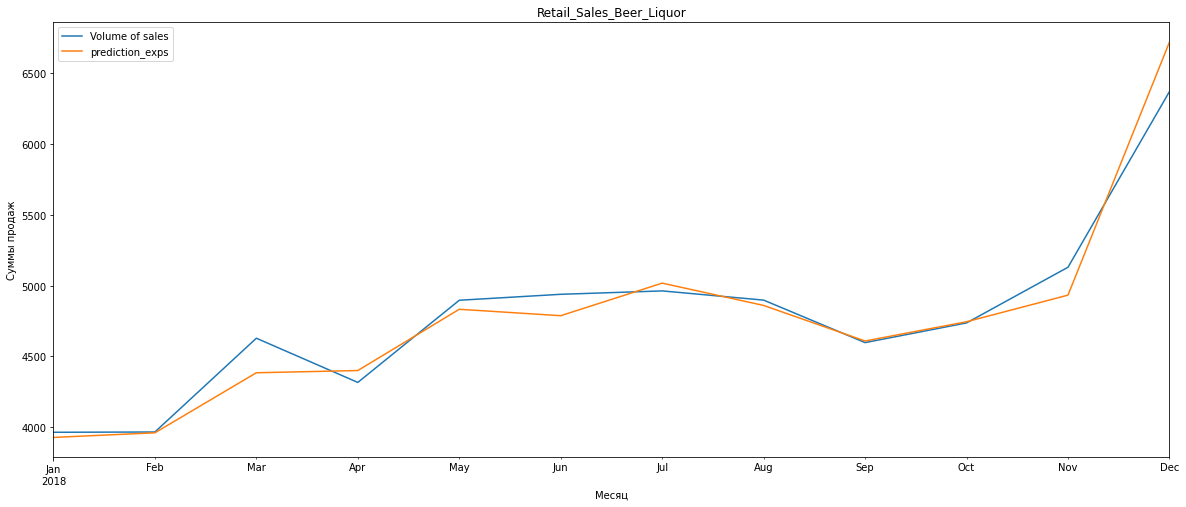

In [65]:
#сравниваем прогноз и тестовую выборку
ax = test['Volume of sales'].plot(legend=True, figsize=(20,8),title='Retail_Sales_Beer_Liquor', ylabel='Суммы продаж',  xlabel='Месяц')
prediction_exps['prediction_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [66]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['Volume of sales'], prediction_exps['prediction_exps'])
mse_error = mean_squared_error(test['Volume of sales'], prediction_exps['prediction_exps'])
rmse_error = rmse(test['Volume of sales'], prediction_exps['prediction_exps'])
mape_error = np.mean(np.abs(prediction_exps['prediction_exps'] - test['Volume of sales'])/test['Volume of sales'])*100

print(f'MAE Error: {mae_error:11.10}')
print(f'MSE Error: {mse_error:11.10}')
print(f'RMSE Error: {rmse_error:11.10}')
print(f'MAPE Error: {mape_error:11.10}')

MAE Error: 103.5647038
MSE Error:  21686.4567
RMSE Error: 147.2632225
MAPE Error: 2.020402968


In [67]:
# делаем прогноз на год вперед

# обучаем модель на всем датасете
fut_model_exps = ExponentialSmoothing(df1['Volume of sales'], seasonal_periods=12, trend = 'add',seasonal="add",initialization_method="estimated",use_boxcox=True) # годовая сезонность
fut_model_exps.fit()

# задаем точки будущего
fut_fcast_exps = fut_model_exps.predict(fut_model_exps.params, start=len(df1)-1, end=len(df1)+11)

# преобразуем в датафрейм с индексами
fut_fcast_exps = pd.DataFrame(fut_fcast_exps)
fut_fcast_exps.index = pd.date_range("2018-12-01 00:00:00", periods=13, freq="MS")
fut_fcast_exps.columns = ['fut_fcast_exps']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [68]:
#проверим
fut_fcast_exps.head(12)

,fut_fcast_exps
2018-12-01,6732.098099
2019-01-01,4088.169884
2019-02-01,4121.720521
2019-03-01,4596.261317
2019-04-01,4559.136085
2019-05-01,5036.002477
2019-06-01,5000.720658
2019-07-01,5205.740627
2019-08-01,5057.062945
2019-09-01,4791.558906


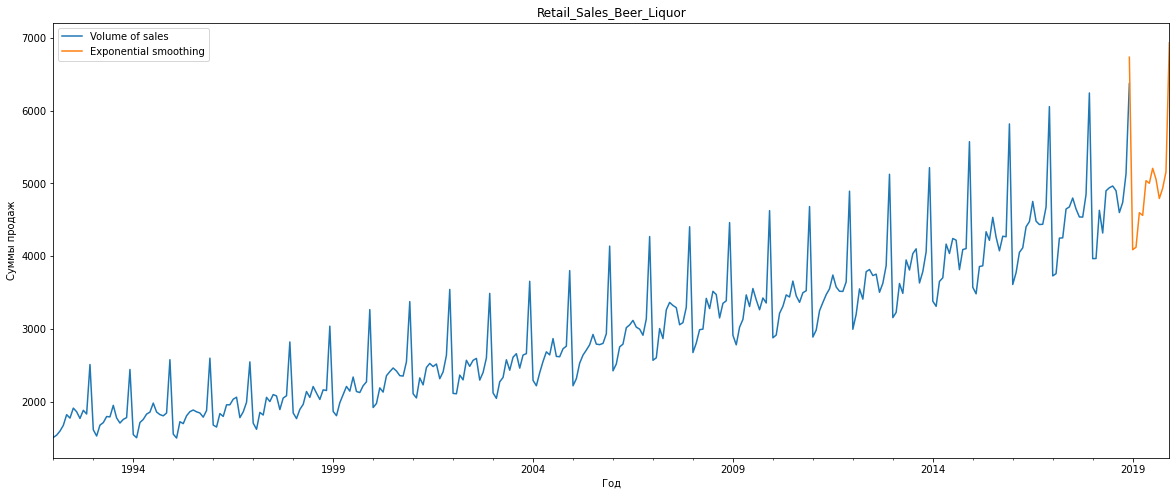

In [69]:
#строим график на будущее
ax = df1['Volume of sales'].plot(legend=True, figsize=(20,8),title='Retail_Sales_Beer_Liquor') 
fut_fcast_exps['fut_fcast_exps'].tail(13).plot(legend=True, ylabel='Суммы продаж',  xlabel='Год')
ax.autoscale(axis='x',tight=True)
ax.legend(["Volume of sales", "Exponential smoothing"]);


### Выводы работы метода Exponential smoothing
Модель показала себя хорошо:
1. Модель показала себя хорошо: RMSE=147.26- это хороший показатель.
2. Процент рассчитанной ошибки MAPE=2.02%, это хороший результат.
3. Согласно графику, на будущее видим, что тренд и высота амплитуда были отображены корректно, общая динамика прослеживается.

## Выводы

1. Проведен анализ данных с использованием методов обработки статистической информации. 
2. Рассчитаны основные статистические метрики, позволяющие судить о характере исследуемого явления.
3. Прогнозная модель позволила зафиксировать сохранение тенденции роста суммы продаж по сравнению с предыдущим годом, а также сохранение амплитудных значений в период новогодних праздников.
